In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, load_digits
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve
from scipy.special import softmax
import keras
keras.backend.set_floatx('float64')

from keras import Sequential
from keras.layers import Dense, Dropout
from keras.activations import relu
from keras.optimizers import RMSprop,Adam
from keras.losses import CategoricalCrossentropy


Using TensorFlow backend.


In [2]:
CCE = CategoricalCrossentropy()

In [3]:
np.random.seed(1234)

In [4]:


iris_dataset = load_digits()
lb = LabelBinarizer()


X = iris_dataset.data
y = iris_dataset.target


lb.fit(y)


data = np.concatenate((X,y.reshape(-1,1)), axis = 1)
np.random.shuffle(data)


X_train = data[:, :-1]

ss = StandardScaler()

X_train = ss.fit_transform(X_train)

y_train = lb.transform( data[: , -1].reshape(-1,1) )

X_train.shape, y_train.shape

((1797, 64), (1797, 10))

In [5]:
def Relu(x):
    return np.maximum(0,x)


def derivative_Relu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x



def relu_activation_derivative(dA, Z):
    
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    
    return dZ


def my_softmax(x, axis = 1):
        
    x -= np.max(x, axis=axis, keepdims=True)
    return np.exp(x) / np.exp(x).sum(axis=axis, keepdims=True)




def softmax_grad(softmax):
    # Reshape the 1-d softmax to 2-d so that np.dot will do the matrix multiplication
    s = softmax.reshape(-1,3)
    return np.diagflat(s) - np.dot(s, s.T)


In [6]:
def NN(lr, epochs = 200, Dropout = True, BatchNorm = False, algo = "Momentum",
       nesterov = False, Use_new = False, dictionary = None):
    
    parameters = { }
    
    activations = { }
    
    Derivatives = { }
    
    Loss = []
    
    if not Use_new:
        theta1 = np.random.randn(64, 32) * ( np.sqrt(2/64) ) # 2/fan_in
        theta2 = np.random.randn(32, 16) * ( np.sqrt(2/24) ) # 2 / (fan_in + fan_out / 2) if unequal, 2/fan_in if equal
        theta3 = np.random.randn(16, 10) * ( np.sqrt(1/26) ) # 1/fan_in + fan_out

    
    elif Use_new:
        theta1 = dictionary["theta1"];
        theta2 = dictionary["theta2"];
        theta3 = dictionary["theta3"]
    

    for i in range(epochs):

        Z1 = X_train.dot(theta1)
        A1 = relu(Z1).numpy()
        
        if Dropout:
            # Drop out probability
            drop_A1 = np.random.rand(A1.shape[0], A1.shape[1]) < 1.0
            A1 *= drop_A1
            A1 /= 1.0
            
        Z2 = A1.dot(theta2)
        A2 = relu(Z2).numpy()
           
        if Dropout:
            # Drop out probability
            drop_A2 = np.random.rand(A2.shape[0], A2.shape[1]) < 1.0
            A2 *= drop_A2
            A2 /= 1.0

        
        Z3 = A2.dot(theta3)
        A3 = softmax(Z3, axis = 1)

        le = CCE(y_train,A3 ).numpy()
        if i% 20 == 0 or i == (epochs-1):
            
            
            print( "Epoch: {} , loss: {}".format(i, le ) )
            
        Loss.append(le)

            
        # Backward
        DZ3_W3 = A2.T
        DL_DW3 = ( DZ3_W3.dot( A3 - y_train )  ) / X_train.shape[0]
        DL_DZ3 = A3 - y_train


        DL_A2 = (DL_DZ3).dot(theta3.T)
        DA2_Z2 = derivative_Relu(Z2)
        DZ2_W2 = A1.T

        DL_DW2 = (DZ2_W2.dot(DL_A2* DA2_Z2)  ) / X_train.shape[0]
        DL_DZ2 = DL_A2 * DA2_Z2


        DL_A1 = DL_DZ2.dot(theta2.T)
        DA1_Z1 = derivative_Relu(Z1)
        DZ1_W1 = X_train.T
        

        DL_DW1 = DZ1_W1.dot( DL_A1 * DA1_Z1 ) / X_train.shape[0]
        
        

        if algo == "Momentum":

            if i == 0:
                Beta = np.float64(0.9)
                m1 = np.zeros(DL_DW1.shape); m2 = np.zeros(DL_DW2.shape); m3 = np.zeros(DL_DW3.shape)

            Bm1 = (Beta * m1); Bm2 = (Beta * m2); Bm3 = (Beta * m3)

            if nesterov:
                # Nesterov Momentum optimization 
                m1 = Bm1 - ( lr * ( DL_DW1 + Bm1 ) )
                m2 = Bm2 - ( lr * ( DL_DW2 + Bm2 ) )
                m3 = Bm3 - ( lr * ( DL_DW3 + Bm3 ) )

            else:

                # Momentum optimization
                m1 = Bm1 - ( lr * (DL_DW1) )
                m2 = Bm2 - ( lr * (DL_DW2) )
                m3 = Bm3 - ( lr * (DL_DW3) )

            theta1 += m1
            theta2 += m2
            theta3 += m3

        elif algo == "Adagrad":

            if i == 0:
                s1 = np.zeros(DL_DW1.shape); s2= np.zeros(DL_DW2.shape) ; s3 = np.zeros(DL_DW3.shape)

            
            s1 += np.power(DL_DW1, 2); s2+= np.power(DL_DW2, 2) ; s3 += np.power(DL_DW3, 2)
            
            theta1 = theta1 - ( (lr * DL_DW1) / np.sqrt(s1 + 10e-10) )  
            theta2 = theta2 - ( (lr * DL_DW2) / np.sqrt(s2 + 10e-10) )  
            theta3 = theta3 - ( (lr * DL_DW3) / np.sqrt(s3 + 10e-10) )
        
        elif algo == "RMSProp":
            
            if i == 0:
                Beta = np.float64(0.9) 
                s1 = np.zeros_like(DL_DW1, shape= DL_DW1.shape) ; s2 = np.zeros_like(DL_DW2, shape = DL_DW2.shape)
                s3 = np.zeros_like(DL_DW3, shape = DL_DW3.shape)
                
            
            s1 = (Beta * s1) + ( (1 - Beta) * np.power(DL_DW1, 2) )
            s2 = (Beta * s2) + ( (1 - Beta) * np.power(DL_DW2, 2) )
            s3 = (Beta * s3) + ( (1 - Beta) * np.power(DL_DW3, 2) )
            
            theta1 -= ( (lr * DL_DW1) / np.sqrt(s1 + 1e-10) )
            theta2 -= ( (lr * DL_DW2) / np.sqrt(s2 + 1e-10) )
            theta3 -= ( (lr * DL_DW3) / np.sqrt(s3 + 1e-10) )
            
        elif algo == "Adam":
            
            if i == 0:
                Beta1 = np.float64(0.9); Beta2 = np.float64(0.999)
                
                m1 = np.zeros(DL_DW1.shape, dtype = np.float64)
                m2 = np.zeros(DL_DW2.shape,dtype = np.float64)
                m3 = np.zeros(DL_DW3.shape, dtype = np.float64)
                
                s1 = np.zeros(DL_DW1.shape,dtype = np.float64)
                s2 = np.zeros(DL_DW2.shape, dtype = np.float64)
                s3 = np.zeros(DL_DW3.shape, dtype = np.float64)
            
            
            
            m1 = (Beta1 * m1) + ( (1. - Beta1) * DL_DW1 )
            m2 = (Beta1 * m2) + ( (1. - Beta1) * DL_DW2 )
            m3 = (Beta1 * m3) + ( (1. - Beta1) * DL_DW3 )
            
            s1 = (Beta2 * s1) + ( (1. - Beta2) * np.power(DL_DW1, 2) )
            s2 = (Beta2 * s2) + ( (1. - Beta2) * np.power(DL_DW2, 2)  )
            s3 = (Beta2 * s3) + ( (1. - Beta2) * np.power(DL_DW3, 2)  )
            
            
            m1c = m1 / (1. - ( Beta1 ** (i+1) )  )
            m2c = m2 / (1. - ( Beta1 ** (i+1))  )
            m3c = m3 / (1. - ( Beta1 ** (i+1))  )
            
            s1c = s1 / (1. - ( Beta2** (i+1)  )  )
            s2c = s2 / (1. - ( Beta2 ** (i+1))  )
            s3c = s3 / (1. - ( Beta2 ** (i+1))  )
            
            
            tss1 = lr * m1c / ( np.sqrt(s1c+ 1e-8) )
            tss2 = lr * m2c / ( np.sqrt(s2c+ 1e-8) )
            tss3 = lr * m3c / ( np.sqrt(s3c+ 1e-8))
            
            
            theta1 -= tss1
            theta2 -= tss2
            theta3 -= tss3
            
        else:
            pass
            
#             theta1 = theta1 - ( lr * DL_DW1 )
#             theta2 = theta2 - ( lr * DL_DW2 )
#             theta3 = theta3 - ( lr * DL_DW3 )
            
    
    parameters["theta1"] = theta1; parameters["theta2"] = theta2; parameters["theta3"] = theta3
    
    activations["A1"] = A1; activations["A2"] = A2; activations["A3"] = A3
    
    Derivatives["DW1"] = DL_DW1; Derivatives["DW2"] = DL_DW2; Derivatives["DW3"] = DL_DW3
    
    
    return (parameters, activations, Derivatives, Loss)
 
    
            
parameters, activations, Derivatives, Loss = NN(lr = 1e-2 , epochs = 1, 
                                                Dropout = False,
                                                algo = "GD", nesterov = False)

# lr 1e-2, epochs = 500, RMSProp : Epoch: 480 , loss: 0.3465736144979975
# lr 1e-2, epochs = 500, Momentum, No Nesterov: Epoch: 480 , loss: 0.6925557243217672
# lr 1e-2, epochs = 500, Momentum, With Nesterov: Epoch: 480 , loss: 0.6927930940792854



# lr 1e-1, epochs = 500, RMSProp : Epoch: 480 , loss: 0.6931471805599453
# lr 1e-1, epochs = 500, Momentum, No Nesterov:  Epoch: 480 , loss: 0.34657382330524106
# lr 1e-1, epochs = 500, Momentum, With Nesterov: Epoch: 480 , loss: 0.3466761685732003

Epoch: 0 , loss: 2.550101281455826


In [7]:
# a = np.random.randn(4,3)

# r = np.zeros(a.shape)
# w = np.zeros_like(a, shape = a.shape)

In [8]:
ti = 97

In [9]:
# my_softmax( (X_train[ti, : ].reshape(-1,4).dot(theta1)).dot(theta2).dot(theta3) )

In [10]:
y_train[ti]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [11]:
Keras_model  = Sequential()

Keras_model.add( Dense(32, activation='relu', use_bias = False, input_shape = (64, ))  )

Keras_model.add( Dropout(0.0) )

Keras_model.add( Dense (16, activation= 'relu', use_bias=False, input_shape = (32, )))

Keras_model.add( Dropout(0.0) )

Keras_model.add( Dense (10, activation= 'softmax', use_bias=False, input_shape = (16, )))

Adam_optim = Adam(learning_rate=1e-2)

Keras_model.compile(loss='categorical_crossentropy', optimizer=Adam_optim, metrics = ['accuracy'])

In [12]:
Keras_model.fit(X_train, y_train, epochs=500, batch_size=1797)

Epoch 1/500
1797/1797 [==============================] - 0s 26us/step - loss: 2.5161 - accuracy: 0.0835
Epoch 2/500
1797/1797 [==============================] - 0s 2us/step - loss: 2.2224 - accuracy: 0.1464
Epoch 3/500
1797/1797 [==============================] - 0s 2us/step - loss: 2.0335 - accuracy: 0.2588
Epoch 4/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.8704 - accuracy: 0.3851
Epoch 5/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.7187 - accuracy: 0.5170
Epoch 6/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.5699 - accuracy: 0.5927
Epoch 7/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.4241 - accuracy: 0.6372
Epoch 8/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.2832 - accuracy: 0.6689
Epoch 9/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.1490 - accuracy: 0.6978
Epoch 10/500
1797/1797 [==============================] - 0s 3us/step - 

Epoch 80/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 81/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 82/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 83/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 84/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0051 - accuracy: 1.0000
Epoch 85/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 86/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0048 - accuracy: 1.0000
Epoch 87/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 88/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 89/500
1797/1797 [==============================] - 0s 1us

Epoch 159/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 160/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 161/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 162/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 163/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 164/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 165/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 166/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 167/500
1797/1797 [==============================] - 0s 2us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 168/500
1797/1797 [==============================

Epoch 236/500
1797/1797 [==============================] - 0s 2us/step - loss: 6.8725e-04 - accuracy: 1.0000
Epoch 237/500
1797/1797 [==============================] - 0s 2us/step - loss: 6.8193e-04 - accuracy: 1.0000
Epoch 238/500
1797/1797 [==============================] - 0s 2us/step - loss: 6.7668e-04 - accuracy: 1.0000
Epoch 239/500
1797/1797 [==============================] - 0s 2us/step - loss: 6.7148e-04 - accuracy: 1.0000
Epoch 240/500
1797/1797 [==============================] - 0s 2us/step - loss: 6.6635e-04 - accuracy: 1.0000
Epoch 241/500
1797/1797 [==============================] - 0s 2us/step - loss: 6.6128e-04 - accuracy: 1.0000
Epoch 242/500
1797/1797 [==============================] - 0s 2us/step - loss: 6.5628e-04 - accuracy: 1.0000
Epoch 243/500
1797/1797 [==============================] - 0s 2us/step - loss: 6.5132e-04 - accuracy: 1.0000
Epoch 244/500
1797/1797 [==============================] - 0s 2us/step - loss: 6.4643e-04 - accuracy: 1.0000
Epoch 245/500
1797/

Epoch 312/500
1797/1797 [==============================] - 0s 2us/step - loss: 4.1192e-04 - accuracy: 1.0000
Epoch 313/500
1797/1797 [==============================] - 0s 2us/step - loss: 4.0952e-04 - accuracy: 1.0000
Epoch 314/500
1797/1797 [==============================] - 0s 2us/step - loss: 4.0714e-04 - accuracy: 1.0000
Epoch 315/500
1797/1797 [==============================] - 0s 2us/step - loss: 4.0478e-04 - accuracy: 1.0000
Epoch 316/500
1797/1797 [==============================] - 0s 2us/step - loss: 4.0245e-04 - accuracy: 1.0000
Epoch 317/500
1797/1797 [==============================] - 0s 2us/step - loss: 4.0014e-04 - accuracy: 1.0000
Epoch 318/500
1797/1797 [==============================] - 0s 2us/step - loss: 3.9784e-04 - accuracy: 1.0000
Epoch 319/500
1797/1797 [==============================] - 0s 2us/step - loss: 3.9557e-04 - accuracy: 1.0000
Epoch 320/500
1797/1797 [==============================] - 0s 2us/step - loss: 3.9333e-04 - accuracy: 1.0000
Epoch 321/500
1797/

Epoch 388/500
1797/1797 [==============================] - 0s 2us/step - loss: 2.7683e-04 - accuracy: 1.0000
Epoch 389/500
1797/1797 [==============================] - 0s 2us/step - loss: 2.7553e-04 - accuracy: 1.0000
Epoch 390/500
1797/1797 [==============================] - 0s 2us/step - loss: 2.7424e-04 - accuracy: 1.0000
Epoch 391/500
1797/1797 [==============================] - 0s 2us/step - loss: 2.7296e-04 - accuracy: 1.0000
Epoch 392/500
1797/1797 [==============================] - 0s 2us/step - loss: 2.7170e-04 - accuracy: 1.0000
Epoch 393/500
1797/1797 [==============================] - 0s 2us/step - loss: 2.7044e-04 - accuracy: 1.0000
Epoch 394/500
1797/1797 [==============================] - 0s 2us/step - loss: 2.6918e-04 - accuracy: 1.0000
Epoch 395/500
1797/1797 [==============================] - 0s 2us/step - loss: 2.6794e-04 - accuracy: 1.0000
Epoch 396/500
1797/1797 [==============================] - 0s 2us/step - loss: 2.6671e-04 - accuracy: 1.0000
Epoch 397/500
1797/

Epoch 464/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.9971e-04 - accuracy: 1.0000
Epoch 465/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.9892e-04 - accuracy: 1.0000
Epoch 466/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.9814e-04 - accuracy: 1.0000
Epoch 467/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.9737e-04 - accuracy: 1.0000
Epoch 468/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.9660e-04 - accuracy: 1.0000
Epoch 469/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.9583e-04 - accuracy: 1.0000
Epoch 470/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.9507e-04 - accuracy: 1.0000
Epoch 471/500
1797/1797 [==============================] - 0s 1us/step - loss: 1.9431e-04 - accuracy: 1.0000
Epoch 472/500
1797/1797 [==============================] - 0s 2us/step - loss: 1.9356e-04 - accuracy: 1.0000
Epoch 473/500
1797/

In [13]:
# Keras_model.predict_proba(X_train[ti, : ].reshape(-1,4))

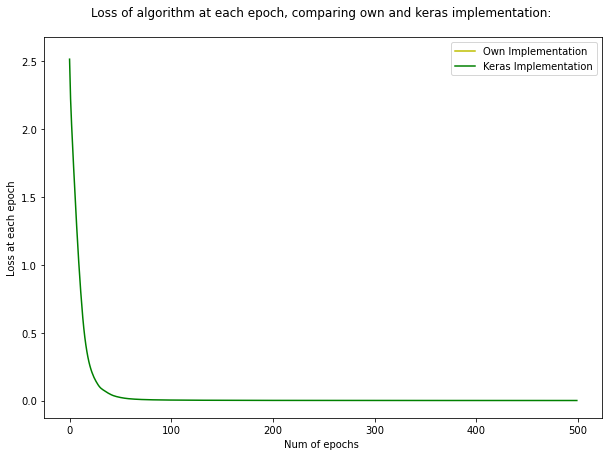

In [14]:

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(Loss, color = 'y')
plt.plot(Keras_model.history.history["loss"], color = 'g')
plt.legend(["Own Implementation", "Keras Implementation"])
plt.title("Loss of algorithm at each epoch, comparing own and keras implementation: \n")
plt.xlabel("Num of epochs ")
plt.ylabel("Loss at each epoch")

plt.show()



In [15]:
def dictionary_to_vector(parameters):
    """
    Roll all our parameters dictionary into a single vector satisfying our specific required shape.
    """
    keys = []
    count = 0
    for key in ["theta1", "theta2", "theta3"]:
        
        # flatten parameter
        new_vector = np.reshape(parameters[key], (-1,1))
        keys = keys + [key]*new_vector.shape[0]
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta, keys

def vector_to_dictionary(theta):
    """
    Unroll all our parameters dictionary from a single vector satisfying our specific required shape.
    """
    parameters = {}
    parameters["theta1"] = theta[:2048].reshape((64,32))
#     parameters["b1"] = theta[20:25].reshape((5,1))
    parameters["theta2"] = theta[2048:2560].reshape((32,16))
#     parameters["b2"] = theta[40:43].reshape((3,1))
    parameters["theta3"] = theta[2560:].reshape((16,10))
#     parameters["b3"] = theta[46:47].reshape((1,1))

    return parameters

def gradients_to_vector(gradients):
    """
    Roll all our gradients dictionary into a single vector satisfying our specific required shape.
    """
    
    count = 0
    for key in ["DW1", "DW2", "DW3"]:
        # flatten parameter
        new_vector = np.reshape(gradients[key], (-1,1))
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta

In [16]:
parameter_values,_ = dictionary_to_vector(parameters)
grad = gradients_to_vector(Derivatives)
numparams = parameter_values.shape[0]
J_plus = np.zeros((numparams, 1))
J_minus = np.zeros((numparams, 1))
gradapprox = np.zeros((numparams, 1))
ep = 1e-7

In [17]:
parameter_values.shape

(2720, 1)

In [18]:
for i in range(numparams):
    
    thetaplus = np.copy(parameter_values)
    thetaplus[i][0] = thetaplus[i][0] + ep
    
    _, _, _, J_plus[i] = NN(lr = 1e-2 , epochs = 1, algo = "GD", nesterov = True, Use_new=True,
                           dictionary = vector_to_dictionary(thetaplus))
    
    
    thetaminus = np.copy(parameter_values)                                       # Step 1
    thetaminus[i][0] = thetaminus[i][0] - ep                                # Step 2        
    
    _, _, _, J_minus[i] = NN(lr = 1e-2 , epochs = 1, algo = "GD", nesterov = True, Use_new=True,
                           dictionary = vector_to_dictionary(thetaminus))
    

    ### START CODE HERE ### (approx. 1 line)
    gradapprox[i] = ( (J_plus[i] - J_minus[i]) / (2 * ep) )

Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.5

Epoch: 0 , loss: 2.5501012818638897
Epoch: 0 , loss: 2.550101280792194
Epoch: 0 , loss: 2.5501012821194577
Epoch: 0 , loss: 2.550101280941393
Epoch: 0 , loss: 2.550101281970261
Epoch: 0 , loss: 2.5501012814589075
Epoch: 0 , loss: 2.550101281452746
Epoch: 0 , loss: 2.5501012811264654
Epoch: 0 , loss: 2.550101281785194
Epoch: 0 , loss: 2.5501012815717066
Epoch: 0 , loss: 2.5501012813399475
Epoch: 0 , loss: 2.5501012821925086
Epoch: 0 , loss: 2.5501012807191423
Epoch: 0 , loss: 2.5501012835093895
Epoch: 0 , loss: 2.550101279402266
Epoch: 0 , loss: 2.5501012823296856
Epoch: 0 , loss: 2.5501012805819667
Epoch: 0 , loss: 2.5501012815619832
Epoch: 0 , loss: 2.5501012813496686
Epoch: 0 , loss: 2.5501012819881375
Epoch: 0 , loss: 2.5501012809235157
Epoch: 0 , loss: 2.55010128389589
Epoch: 0 , loss: 2.5501012790157613
Epoch: 0 , loss: 2.5501012808200296
Epoch: 0 , loss: 2.550101282091627
Epoch: 0 , loss: 2.550101282302483
Epoch: 0 , loss: 2.5501012806091716
Epoch: 0 , loss: 2.5501012823328555
Ep

Epoch: 0 , loss: 2.55010128197788
Epoch: 0 , loss: 2.5501012809337777
Epoch: 0 , loss: 2.5501012833580283
Epoch: 0 , loss: 2.5501012795536266
Epoch: 0 , loss: 2.5501012817760675
Epoch: 0 , loss: 2.550101281135587
Epoch: 0 , loss: 2.5501012812817425
Epoch: 0 , loss: 2.5501012816299102
Epoch: 0 , loss: 2.550101281479963
Epoch: 0 , loss: 2.5501012814316897
Epoch: 0 , loss: 2.550101281062345
Epoch: 0 , loss: 2.5501012818493116
Epoch: 0 , loss: 2.55010128170964
Epoch: 0 , loss: 2.550101281202014
Epoch: 0 , loss: 2.55010128199398
Epoch: 0 , loss: 2.5501012809176697
Epoch: 0 , loss: 2.55010128067336
Epoch: 0 , loss: 2.550101282238292
Epoch: 0 , loss: 2.5501012819313216
Epoch: 0 , loss: 2.5501012809803387
Epoch: 0 , loss: 2.550101281431171
Epoch: 0 , loss: 2.550101281480485
Epoch: 0 , loss: 2.5501012813696557
Epoch: 0 , loss: 2.5501012815419957
Epoch: 0 , loss: 2.5501012814079322
Epoch: 0 , loss: 2.5501012815037227
Epoch: 0 , loss: 2.550101281494883
Epoch: 0 , loss: 2.5501012814167656
Epoch: 0

Epoch: 0 , loss: 2.550101280476134
Epoch: 0 , loss: 2.55010128074894
Epoch: 0 , loss: 2.550101282162711
Epoch: 0 , loss: 2.5501012811120702
Epoch: 0 , loss: 2.5501012817995807
Epoch: 0 , loss: 2.5501012806302286
Epoch: 0 , loss: 2.5501012822814273
Epoch: 0 , loss: 2.5501012827034892
Epoch: 0 , loss: 2.5501012802081626
Epoch: 0 , loss: 2.5501012816386615
Epoch: 0 , loss: 2.5501012812729957
Epoch: 0 , loss: 2.5501012822596203
Epoch: 0 , loss: 2.550101280652035
Epoch: 0 , loss: 2.550101281434977
Epoch: 0 , loss: 2.5501012814766755
Epoch: 0 , loss: 2.5501012818454663
Epoch: 0 , loss: 2.5501012810661856
Epoch: 0 , loss: 2.550101280708273
Epoch: 0 , loss: 2.5501012822033795
Epoch: 0 , loss: 2.5501012809312735
Epoch: 0 , loss: 2.5501012819803788
Epoch: 0 , loss: 2.5501012833248455
Epoch: 0 , loss: 2.5501012795868085
Epoch: 0 , loss: 2.5501012822588285
Epoch: 0 , loss: 2.550101280652823
Epoch: 0 , loss: 2.550101281472091
Epoch: 0 , loss: 2.5501012814395576
Epoch: 0 , loss: 2.5501012809476027
E

Epoch: 0 , loss: 2.550101281736649
Epoch: 0 , loss: 2.550101281175004
Epoch: 0 , loss: 2.5501012815989816
Epoch: 0 , loss: 2.5501012813126693
Epoch: 0 , loss: 2.550101280468092
Epoch: 0 , loss: 2.5501012824435665
Epoch: 0 , loss: 2.550101282909128
Epoch: 0 , loss: 2.5501012800025236
Epoch: 0 , loss: 2.550101281603266
Epoch: 0 , loss: 2.5501012813083865
Epoch: 0 , loss: 2.550101281359709
Epoch: 0 , loss: 2.5501012815519437
Epoch: 0 , loss: 2.5501012811388986
Epoch: 0 , loss: 2.550101281772754
Epoch: 0 , loss: 2.550101281839013
Epoch: 0 , loss: 2.550101281072642
Epoch: 0 , loss: 2.5501012813412327
Epoch: 0 , loss: 2.550101281570424
Epoch: 0 , loss: 2.550101282089093
Epoch: 0 , loss: 2.5501012808225636
Epoch: 0 , loss: 2.5501012830341057
Epoch: 0 , loss: 2.5501012798775466
Epoch: 0 , loss: 2.5501012816774655
Epoch: 0 , loss: 2.550101281234186
Epoch: 0 , loss: 2.5501012814243937
Epoch: 0 , loss: 2.5501012814872572
Epoch: 0 , loss: 2.5501012817090833
Epoch: 0 , loss: 2.5501012812025703
Epoc

Epoch: 0 , loss: 2.5501012820909974
Epoch: 0 , loss: 2.5501012833980425
Epoch: 0 , loss: 2.5501012795136093
Epoch: 0 , loss: 2.550101281009073
Epoch: 0 , loss: 2.550101281902582
Epoch: 0 , loss: 2.5501012837739214
Epoch: 0 , loss: 2.5501012791377287
Epoch: 0 , loss: 2.5501012822598446
Epoch: 0 , loss: 2.550101280651808
Epoch: 0 , loss: 2.550101281833995
Epoch: 0 , loss: 2.550101281077658
Epoch: 0 , loss: 2.550101281635079
Epoch: 0 , loss: 2.5501012812765755
Epoch: 0 , loss: 2.5501012796263933
Epoch: 0 , loss: 2.5501012832852585
Epoch: 0 , loss: 2.5501012826901657
Epoch: 0 , loss: 2.550101280221487
Epoch: 0 , loss: 2.550101280086269
Epoch: 0 , loss: 2.5501012828253806
Epoch: 0 , loss: 2.550101281292256
Epoch: 0 , loss: 2.5501012816193978
Epoch: 0 , loss: 2.55010128121906
Epoch: 0 , loss: 2.5501012816925934
Epoch: 0 , loss: 2.550101282830362
Epoch: 0 , loss: 2.5501012800812926
Epoch: 0 , loss: 2.550101280393627
Epoch: 0 , loss: 2.550101282518032
Epoch: 0 , loss: 2.5501012823695115
Epoch:

Epoch: 0 , loss: 2.5501012815445665
Epoch: 0 , loss: 2.5501012812934865
Epoch: 0 , loss: 2.550101281618167
Epoch: 0 , loss: 2.5501012813038675
Epoch: 0 , loss: 2.5501012816077853
Epoch: 0 , loss: 2.5501012806833563
Epoch: 0 , loss: 2.5501012822282947
Epoch: 0 , loss: 2.550101281490061
Epoch: 0 , loss: 2.550101281421589
Epoch: 0 , loss: 2.550101281852793
Epoch: 0 , loss: 2.550101281058858
Epoch: 0 , loss: 2.5501012814915853
Epoch: 0 , loss: 2.5501012814200665
Epoch: 0 , loss: 2.5501012811379593
Epoch: 0 , loss: 2.5501012817736974
Epoch: 0 , loss: 2.550101282193735
Epoch: 0 , loss: 2.5501012807179193
Epoch: 0 , loss: 2.5501012815620823
Epoch: 0 , loss: 2.55010128134957
Epoch: 0 , loss: 2.5501012813873056
Epoch: 0 , loss: 2.5501012815243462
Epoch: 0 , loss: 2.550101281754575
Epoch: 0 , loss: 2.5501012811570782
Epoch: 0 , loss: 2.5501012814409942
Epoch: 0 , loss: 2.5501012814706603
Epoch: 0 , loss: 2.55010128119211
Epoch: 0 , loss: 2.550101281719545
Epoch: 0 , loss: 2.550101282333592
Epoch

Epoch: 0 , loss: 2.5501012820283404
Epoch: 0 , loss: 2.5501012823203224
Epoch: 0 , loss: 2.5501012805913286
Epoch: 0 , loss: 2.5501012835646897
Epoch: 0 , loss: 2.5501012793469613
Epoch: 0 , loss: 2.5501012821695923
Epoch: 0 , loss: 2.5501012807420644
Epoch: 0 , loss: 2.55010127926921
Epoch: 0 , loss: 2.5501012836424426
Epoch: 0 , loss: 2.5501012823112044
Epoch: 0 , loss: 2.550101280600451
Epoch: 0 , loss: 2.550101283050346
Epoch: 0 , loss: 2.550101279861307
Epoch: 0 , loss: 2.5501012812752024
Epoch: 0 , loss: 2.5501012816364526
Epoch: 0 , loss: 2.5501012830705934
Epoch: 0 , loss: 2.550101279841056
Epoch: 0 , loss: 2.5501012826255494
Epoch: 0 , loss: 2.550101280286103
Epoch: 0 , loss: 2.5501012827456813
Epoch: 0 , loss: 2.550101280165972
Epoch: 0 , loss: 2.550101281747216
Epoch: 0 , loss: 2.5501012811644403
Epoch: 0 , loss: 2.550101279547847
Epoch: 0 , loss: 2.550101283363805
Epoch: 0 , loss: 2.550101282421992
Epoch: 0 , loss: 2.5501012804896592
Epoch: 0 , loss: 2.55010128057769
Epoch:

Epoch: 0 , loss: 2.5501012821227023
Epoch: 0 , loss: 2.5501012807889536
Epoch: 0 , loss: 2.5501012814396615
Epoch: 0 , loss: 2.55010128147199
Epoch: 0 , loss: 2.5501012813863593
Epoch: 0 , loss: 2.5501012815252913
Epoch: 0 , loss: 2.550101282483131
Epoch: 0 , loss: 2.55010128042852
Epoch: 0 , loss: 2.5501012823732347
Epoch: 0 , loss: 2.5501012805384193
Epoch: 0 , loss: 2.550101281261597
Epoch: 0 , loss: 2.550101281650057
Epoch: 0 , loss: 2.550101281535637
Epoch: 0 , loss: 2.5501012813760187
Epoch: 0 , loss: 2.550101281385318
Epoch: 0 , loss: 2.5501012815263393
Epoch: 0 , loss: 2.5501012818476108
Epoch: 0 , loss: 2.5501012810640393
Epoch: 0 , loss: 2.550101281112027
Epoch: 0 , loss: 2.5501012817996256
Epoch: 0 , loss: 2.550101281407491
Epoch: 0 , loss: 2.5501012815041646
Epoch: 0 , loss: 2.5501012816493596
Epoch: 0 , loss: 2.5501012812622914
Epoch: 0 , loss: 2.5501012817527595
Epoch: 0 , loss: 2.5501012811588915
Epoch: 0 , loss: 2.550101281151714
Epoch: 0 , loss: 2.5501012817599418
Epoc

Epoch: 0 , loss: 2.5501012816300883
Epoch: 0 , loss: 2.550101278816346
Epoch: 0 , loss: 2.5501012840953092
Epoch: 0 , loss: 2.550101282566678
Epoch: 0 , loss: 2.5501012803449754
Epoch: 0 , loss: 2.55010127979405
Epoch: 0 , loss: 2.5501012831176038
Epoch: 0 , loss: 2.5501012807820658
Epoch: 0 , loss: 2.5501012821295874
Epoch: 0 , loss: 2.550101278305487
Epoch: 0 , loss: 2.5501012846061633
Epoch: 0 , loss: 2.5501012810908232
Epoch: 0 , loss: 2.5501012818208224
Epoch: 0 , loss: 2.550101285615046
Epoch: 0 , loss: 2.5501012772966067
Epoch: 0 , loss: 2.5501012808096424
Epoch: 0 , loss: 2.5501012821020113
Epoch: 0 , loss: 2.550101280110887
Epoch: 0 , loss: 2.550101282800768
Epoch: 0 , loss: 2.550101279812974
Epoch: 0 , loss: 2.550101283098679
Epoch: 0 , loss: 2.550101281688951
Epoch: 0 , loss: 2.5501012812227053
Epoch: 0 , loss: 2.5501012831165326
Epoch: 0 , loss: 2.5501012797951197
Epoch: 0 , loss: 2.5501012787247985
Epoch: 0 , loss: 2.5501012841868547
Epoch: 0 , loss: 2.550101282311497
Epoc

Epoch: 0 , loss: 2.55010128258736
Epoch: 0 , loss: 2.550101280324291
Epoch: 0 , loss: 2.5501012818507687
Epoch: 0 , loss: 2.5501012810608827
Epoch: 0 , loss: 2.550101282531126
Epoch: 0 , loss: 2.550101280380528
Epoch: 0 , loss: 2.550101282941309
Epoch: 0 , loss: 2.5501012799703413
Epoch: 0 , loss: 2.5501012808044172
Epoch: 0 , loss: 2.5501012821072337
Epoch: 0 , loss: 2.550101280321123
Epoch: 0 , loss: 2.550101282590532
Epoch: 0 , loss: 2.5501012808103938
Epoch: 0 , loss: 2.550101282101262
Epoch: 0 , loss: 2.550101280715587
Epoch: 0 , loss: 2.5501012821960676
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , loss: 2.550101281455826
Epoch: 0 , los

Epoch: 0 , loss: 2.550101279914574
Epoch: 0 , loss: 2.5501012829970833
Epoch: 0 , loss: 2.550101281097853
Epoch: 0 , loss: 2.550101281813799
Epoch: 0 , loss: 2.5501012815407114
Epoch: 0 , loss: 2.55010128137094
Epoch: 0 , loss: 2.550101282211993
Epoch: 0 , loss: 2.5501012806996575
Epoch: 0 , loss: 2.550101281449568
Epoch: 0 , loss: 2.5501012814620823
Epoch: 0 , loss: 2.5501012803519894
Epoch: 0 , loss: 2.550101282559663
Epoch: 0 , loss: 2.5501012831962186
Epoch: 0 , loss: 2.550101279715435
Epoch: 0 , loss: 2.5501012824322062
Epoch: 0 , loss: 2.550101280479447
Epoch: 0 , loss: 2.550101280826513
Epoch: 0 , loss: 2.550101282085141
Epoch: 0 , loss: 2.550101279101537
Epoch: 0 , loss: 2.5501012838101182
Epoch: 0 , loss: 2.550101283292525
Epoch: 0 , loss: 2.5501012796191294
Epoch: 0 , loss: 2.550101280619174
Epoch: 0 , loss: 2.5501012822924785
Epoch: 0 , loss: 2.5501012791983335
Epoch: 0 , loss: 2.550101283713319
Epoch: 0 , loss: 2.550101277763996
Epoch: 0 , loss: 2.5501012851476537
Epoch: 0 

Epoch: 0 , loss: 2.5501012797700824
Epoch: 0 , loss: 2.550101282720311
Epoch: 0 , loss: 2.550101280191343
Epoch: 0 , loss: 2.5501012810025228
Epoch: 0 , loss: 2.5501012819091278
Epoch: 0 , loss: 2.5501012782991705
Epoch: 0 , loss: 2.550101284612485
Epoch: 0 , loss: 2.5501012823327356
Epoch: 0 , loss: 2.5501012805789207
Epoch: 0 , loss: 2.5501012799186613
Epoch: 0 , loss: 2.55010128299299
Epoch: 0 , loss: 2.5501012806979606
Epoch: 0 , loss: 2.5501012822136935
Epoch: 0 , loss: 2.5501012810318513
Epoch: 0 , loss: 2.5501012818798
Epoch: 0 , loss: 2.550101282197832
Epoch: 0 , loss: 2.5501012807138177
Epoch: 0 , loss: 2.5501012801005682
Epoch: 0 , loss: 2.550101282811083
Epoch: 0 , loss: 2.5501012807697667
Epoch: 0 , loss: 2.5501012821418843
Epoch: 0 , loss: 2.550101280680998
Epoch: 0 , loss: 2.550101282230655
Epoch: 0 , loss: 2.5501012816816417
Epoch: 0 , loss: 2.5501012812300115
Epoch: 0 , loss: 2.5501012806980787
Epoch: 0 , loss: 2.5501012822135785
Epoch: 0 , loss: 2.550101283543806
Epoch

Epoch: 0 , loss: 2.5501012834756143
Epoch: 0 , loss: 2.5501012794360425
Epoch: 0 , loss: 2.550101281417056
Epoch: 0 , loss: 2.5501012814945945
Epoch: 0 , loss: 2.550101281626428
Epoch: 0 , loss: 2.5501012812852246
Epoch: 0 , loss: 2.5501012825784977
Epoch: 0 , loss: 2.550101280333151
Epoch: 0 , loss: 2.550101281978898
Epoch: 0 , loss: 2.550101280932752
Epoch: 0 , loss: 2.550101280603972
Epoch: 0 , loss: 2.5501012823076823
Epoch: 0 , loss: 2.550101279198137
Epoch: 0 , loss: 2.5501012837135177
Epoch: 0 , loss: 2.5501012790600375
Epoch: 0 , loss: 2.550101283851619
Epoch: 0 , loss: 2.550101279256253
Epoch: 0 , loss: 2.550101283655402
Epoch: 0 , loss: 2.5501012802274508
Epoch: 0 , loss: 2.5501012826841998
Epoch: 0 , loss: 2.5501012812321675
Epoch: 0 , loss: 2.550101281679483
Epoch: 0 , loss: 2.5501012818200373
Epoch: 0 , loss: 2.5501012810916124
Epoch: 0 , loss: 2.5501012807757903
Epoch: 0 , loss: 2.5501012821358593
Epoch: 0 , loss: 2.550101282570002
Epoch: 0 , loss: 2.5501012803416505
Epoc

Epoch: 0 , loss: 2.5501012806727776
Epoch: 0 , loss: 2.5501012785187287
Epoch: 0 , loss: 2.5501012843929223
Epoch: 0 , loss: 2.550101284097004
Epoch: 0 , loss: 2.5501012788146493
Epoch: 0 , loss: 2.5501012840857262
Epoch: 0 , loss: 2.5501012788259243
Epoch: 0 , loss: 2.5501012834486887
Epoch: 0 , loss: 2.5501012794629663
Epoch: 0 , loss: 2.5501012805434664
Epoch: 0 , loss: 2.550101282368185
Epoch: 0 , loss: 2.5501012818984674
Epoch: 0 , loss: 2.550101281013185
Epoch: 0 , loss: 2.550101282957812
Epoch: 0 , loss: 2.550101279953838
Epoch: 0 , loss: 2.5501012822456723
Epoch: 0 , loss: 2.550101280665981
Epoch: 0 , loss: 2.5501012806028034
Epoch: 0 , loss: 2.550101282308852
Epoch: 0 , loss: 2.5501012793969995
Epoch: 0 , loss: 2.5501012835146577
Epoch: 0 , loss: 2.55010128277659
Epoch: 0 , loss: 2.5501012801350664
Epoch: 0 , loss: 2.5501012819644213
Epoch: 0 , loss: 2.550101280947235
Epoch: 0 , loss: 2.55010128035487
Epoch: 0 , loss: 2.5501012825567813
Epoch: 0 , loss: 2.5501012810778723
Epoc

Epoch: 0 , loss: 2.5501012817113224
Epoch: 0 , loss: 2.5501012812003307
Epoch: 0 , loss: 2.550101283562654
Epoch: 0 , loss: 2.550101279348999
Epoch: 0 , loss: 2.5501012813480113
Epoch: 0 , loss: 2.5501012815636424
Epoch: 0 , loss: 2.550101281728313
Epoch: 0 , loss: 2.5501012811833372
Epoch: 0 , loss: 2.550101280760702
Epoch: 0 , loss: 2.5501012821509486
Epoch: 0 , loss: 2.5501012815107953
Epoch: 0 , loss: 2.5501012814008583
Epoch: 0 , loss: 2.5501012814924953
Epoch: 0 , loss: 2.5501012814191566
Epoch: 0 , loss: 2.550101281074341
Epoch: 0 , loss: 2.550101281837315
Epoch: 0 , loss: 2.5501012823961138
Epoch: 0 , loss: 2.5501012805155368
Epoch: 0 , loss: 2.5501012807360075
Epoch: 0 , loss: 2.550101282175644
Epoch: 0 , loss: 2.5501012816748596
Epoch: 0 , loss: 2.5501012812367914
Epoch: 0 , loss: 2.55010128131784
Epoch: 0 , loss: 2.550101281593812
Epoch: 0 , loss: 2.550101281904569
Epoch: 0 , loss: 2.550101281007084
Epoch: 0 , loss: 2.55010128250983
Epoch: 0 , loss: 2.550101280401824
Epoch: 

Epoch: 0 , loss: 2.550101282444117
Epoch: 0 , loss: 2.550101281733009
Epoch: 0 , loss: 2.5501012811786414
Epoch: 0 , loss: 2.550101279301118
Epoch: 0 , loss: 2.550101283610536
Epoch: 0 , loss: 2.5501012811971226
Epoch: 0 , loss: 2.5501012817145328
Epoch: 0 , loss: 2.5501012802807668
Epoch: 0 , loss: 2.550101282630891
Epoch: 0 , loss: 2.55010128119165
Epoch: 0 , loss: 2.5501012817200053
Epoch: 0 , loss: 2.5501012817960826
Epoch: 0 , loss: 2.550101281115569
Epoch: 0 , loss: 2.550101281228636
Epoch: 0 , loss: 2.550101281683018
Epoch: 0 , loss: 2.5501012811436303
Epoch: 0 , loss: 2.5501012817680184
Epoch: 0 , loss: 2.550101282105805
Epoch: 0 , loss: 2.5501012808058485
Epoch: 0 , loss: 2.550101282157629
Epoch: 0 , loss: 2.550101280754022
Epoch: 0 , loss: 2.550101282033366
Epoch: 0 , loss: 2.550101280878287
Epoch: 0 , loss: 2.550101281633264
Epoch: 0 , loss: 2.550101281278388
Epoch: 0 , loss: 2.550101281560496
Epoch: 0 , loss: 2.550101281351155
Epoch: 0 , loss: 2.5501012818404276
Epoch: 0 , 

Epoch: 0 , loss: 2.5501012806570476
Epoch: 0 , loss: 2.550101282254605
Epoch: 0 , loss: 2.5501012817856936
Epoch: 0 , loss: 2.5501012811259582
Epoch: 0 , loss: 2.5501012815184527
Epoch: 0 , loss: 2.5501012813931987
Epoch: 0 , loss: 2.5501012834043
Epoch: 0 , loss: 2.550101279507352
Epoch: 0 , loss: 2.5501012812484984
Epoch: 0 , loss: 2.550101281663153
Epoch: 0 , loss: 2.5501012833917813
Epoch: 0 , loss: 2.5501012795198696
Epoch: 0 , loss: 2.5501012850961184
Epoch: 0 , loss: 2.5501012778155316
Epoch: 0 , loss: 2.5501012813982045
Epoch: 0 , loss: 2.5501012815134465
Epoch: 0 , loss: 2.5501012838019563
Epoch: 0 , loss: 2.5501012791097013
Epoch: 0 , loss: 2.5501012887867622
Epoch: 0 , loss: 2.5501012741248905
Epoch: 0 , loss: 2.5501012821543454
Epoch: 0 , loss: 2.5501012807573034
Epoch: 0 , loss: 2.550101281110311
Epoch: 0 , loss: 2.550101281801339
Epoch: 0 , loss: 2.550101281519008
Epoch: 0 , loss: 2.550101281392647
Epoch: 0 , loss: 2.550101281764653
Epoch: 0 , loss: 2.5501012811469983
Epo

Epoch: 0 , loss: 2.5501012801575635
Epoch: 0 , loss: 2.5501012827540883
Epoch: 0 , loss: 2.5501012813348067
Epoch: 0 , loss: 2.550101281576844
Epoch: 0 , loss: 2.550101281592712
Epoch: 0 , loss: 2.550101281318939
Epoch: 0 , loss: 2.55010128165538
Epoch: 0 , loss: 2.5501012812562713
Epoch: 0 , loss: 2.5501012859201073
Epoch: 0 , loss: 2.550101276991544
Epoch: 0 , loss: 2.550101282134665
Epoch: 0 , loss: 2.5501012807769854
Epoch: 0 , loss: 2.5501012815084825
Epoch: 0 , loss: 2.5501012814031694
Epoch: 0 , loss: 2.550101285499593
Epoch: 0 , loss: 2.5501012774120606
Epoch: 0 , loss: 2.5501012812555164
Epoch: 0 , loss: 2.550101281656134
Epoch: 0 , loss: 2.5501012842728
Epoch: 0 , loss: 2.5501012786388513
Epoch: 0 , loss: 2.5501012831331398
Epoch: 0 , loss: 2.550101279778511
Epoch: 0 , loss: 2.5501012821633733
Epoch: 0 , loss: 2.5501012807482786
Epoch: 0 , loss: 2.5501012843241466
Epoch: 0 , loss: 2.5501012785875083
Epoch: 0 , loss: 2.5501012868824096
Epoch: 0 , loss: 2.550101276029242
Epoch:

Epoch: 0 , loss: 2.5501012814368003
Epoch: 0 , loss: 2.550101282801209
Epoch: 0 , loss: 2.550101280110444
Epoch: 0 , loss: 2.55010128301776
Epoch: 0 , loss: 2.550101279893892
Epoch: 0 , loss: 2.550101282949775
Epoch: 0 , loss: 2.5501012799618805
Epoch: 0 , loss: 2.5501012833180194
Epoch: 0 , loss: 2.550101279593634
Epoch: 0 , loss: 2.5501012844099993
Epoch: 0 , loss: 2.5501012785016526
Epoch: 0 , loss: 2.550101281812179
Epoch: 0 , loss: 2.5501012810994728
Epoch: 0 , loss: 2.5501012813295922
Epoch: 0 , loss: 2.5501012815820587
Epoch: 0 , loss: 2.550101281650687
Epoch: 0 , loss: 2.5501012812609685
Epoch: 0 , loss: 2.5501012803761642
Epoch: 0 , loss: 2.55010128253549
Epoch: 0 , loss: 2.5501012822215254
Epoch: 0 , loss: 2.55010128069013
Epoch: 0 , loss: 2.55010128144127
Epoch: 0 , loss: 2.550101281470382
Epoch: 0 , loss: 2.550101284529841
Epoch: 0 , loss: 2.5501012783818138
Epoch: 0 , loss: 2.550101282752517
Epoch: 0 , loss: 2.5501012801591347
Epoch: 0 , loss: 2.5501012814564397
Epoch: 0 ,

Epoch: 0 , loss: 2.550101281479511
Epoch: 0 , loss: 2.55010128143214
Epoch: 0 , loss: 2.5501012831706396
Epoch: 0 , loss: 2.5501012797410123
Epoch: 0 , loss: 2.550101281429342
Epoch: 0 , loss: 2.55010128148231
Epoch: 0 , loss: 2.5501012816393858
Epoch: 0 , loss: 2.550101281272265
Epoch: 0 , loss: 2.5501012844356428
Epoch: 0 , loss: 2.55010127847601
Epoch: 0 , loss: 2.550101281332194
Epoch: 0 , loss: 2.5501012815794573
Epoch: 0 , loss: 2.5501012815993267
Epoch: 0 , loss: 2.5501012813123247
Epoch: 0 , loss: 2.5501012818364486
Epoch: 0 , loss: 2.5501012810752015
Epoch: 0 , loss: 2.5501012832089414
Epoch: 0 , loss: 2.550101279702711
Epoch: 0 , loss: 2.550101283500973
Epoch: 0 , loss: 2.5501012794106783
Epoch: 0 , loss: 2.5501012849609404
Epoch: 0 , loss: 2.550101277950708
Epoch: 0 , loss: 2.550101282848978
Epoch: 0 , loss: 2.550101280062674
Epoch: 0 , loss: 2.5501012810596095
Epoch: 0 , loss: 2.5501012818520414
Epoch: 0 , loss: 2.550101281220615
Epoch: 0 , loss: 2.550101281691039
Epoch: 0 

Epoch: 0 , loss: 2.5501012801429814
Epoch: 0 , loss: 2.550101282768671
Epoch: 0 , loss: 2.550101276352044
Epoch: 0 , loss: 2.5501012865596073
Epoch: 0 , loss: 2.5501012825479
Epoch: 0 , loss: 2.550101280363752
Epoch: 0 , loss: 2.5501012820653393
Epoch: 0 , loss: 2.550101280846312
Epoch: 0 , loss: 2.5501012832458545
Epoch: 0 , loss: 2.5501012796657982
Epoch: 0 , loss: 2.550101281670999
Epoch: 0 , loss: 2.5501012812406536
Epoch: 0 , loss: 2.5501012838491515
Epoch: 0 , loss: 2.5501012790625017
Epoch: 0 , loss: 2.5501012949460584
Epoch: 0 , loss: 2.550101267965592
Epoch: 0 , loss: 2.550101275693294
Epoch: 0 , loss: 2.550101287218356
Epoch: 0 , loss: 2.550101277528987
Epoch: 0 , loss: 2.5501012853826652
Epoch: 0 , loss: 2.550101269452573
Epoch: 0 , loss: 2.5501012934590803
Epoch: 0 , loss: 2.550101278948654
Epoch: 0 , loss: 2.550101283962999
Epoch: 0 , loss: 2.550101288197335
Epoch: 0 , loss: 2.55010127471432
Epoch: 0 , loss: 2.550101280859541
Epoch: 0 , loss: 2.5501012820521143
Epoch: 0 , 

In [19]:
numerator = np.linalg.norm(grad - gradapprox)                                    # Step 1'
denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)                   # Step 2'
difference = numerator / denominator                                              # Step 3'
difference

1.89436702317799e-07

In [20]:
numerator

3.666899727524582e-07

In [21]:
denominator

1.935686001001533